In [7]:
#necessary imports

import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [8]:
#importing data using glob

csv_files = glob("./zippedData/*.csv.gz")
csv_files

['./zippedData/imdb.title.crew.csv.gz',
 './zippedData/tmdb.movies.csv.gz',
 './zippedData/imdb.title.akas.csv.gz',
 './zippedData/imdb.title.ratings.csv.gz',
 './zippedData/imdb.name.basics.csv.gz',
 './zippedData/imdb.title.basics.csv.gz',
 './zippedData/tn.movie_budgets.csv.gz',
 './zippedData/bom.movie_gross.csv.gz',
 './zippedData/imdb.title.principals.csv.gz']

In [9]:
csv_files_dict = {}
for filename in csv_files:
    filename_cleaned = os.path.basename(filename).replace(".csv", "").replace(".", "_") # cleaning the filenames
    filename_df = pd.read_csv(filename, index_col=0)
    csv_files_dict[filename_cleaned] = filename_df

## Question 1: What are the top 5 grossing films?

In [10]:
movie_budgets_df = csv_files_dict['tn_movie_budgets_gz']

In [11]:
type(movie_budgets_df)

pandas.core.frame.DataFrame

In [12]:
movie_budgets_df.shape

(5782, 5)

In [13]:
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [14]:
movie_budgets_df[movie_budgets_df['movie'] == 'Avatar']

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


In [15]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: object(5)
memory usage: 271.0+ KB


In [16]:
movie_budgets_df.isna().sum()

release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

The columns of production_budget, domestic_gross and worldwide_gross seem to contain numbers but their datatype is object. Also at first glance there don't seem to be any missing values

### Data Cleaning

#### Dealing with datatypes

In [17]:
#changing dtype of columns
#we want to change the types of 3 columns. Good idea to write a function for this

def convert_amt_to_int(df, col):
    df[col] = df[col].str.replace("$", "").str.replace(",", "").astype('int')
    return df

In [18]:
#making a list of all the cols where we want to change the dtype 

money_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

for col in money_cols:
    movie_budgets_df = convert_amt_to_int(movie_budgets_df, col)

In [19]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null int64
domestic_gross       5782 non-null int64
worldwide_gross      5782 non-null int64
dtypes: int64(3), object(2)
memory usage: 271.0+ KB


In [20]:
#confirming no na values
movie_budgets_df.isna().sum()

release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

#### Checking the value counts 

In [21]:
#looking at the most occuring values to see if there are any weird values
for col in movie_budgets_df:
    print(f'Viewing values in col: {col}')
    print(f'Top 5 values:\n{movie_budgets_df[col].value_counts(normalize = True)[:5]}')
    print("-------------------")

Viewing values in col: release_date
Top 5 values:
Dec 31, 2014    0.004151
Dec 31, 2015    0.003978
Dec 31, 2010    0.002594
Dec 31, 2008    0.002421
Dec 31, 2009    0.002248
Name: release_date, dtype: float64
-------------------
Viewing values in col: movie
Top 5 values:
King Kong                        0.000519
Home                             0.000519
Halloween                        0.000519
The Day the Earth Stood Still    0.000346
Hercules                         0.000346
Name: movie, dtype: float64
-------------------
Viewing values in col: production_budget
Top 5 values:
20000000    0.039952
10000000    0.036666
30000000    0.030612
15000000    0.029920
25000000    0.029575
Name: production_budget, dtype: float64
-------------------
Viewing values in col: domestic_gross
Top 5 values:
0           0.094777
8000000     0.001557
2000000     0.001211
7000000     0.001211
10000000    0.001038
Name: domestic_gross, dtype: float64
-------------------
Viewing values in col: worldwide_gr

Now that we know our dataframe has clean data, we can start working on the logic needed to get the top 5 grossing movies. As we have the production budget available, we can create a new column which will have the profits the movie has made.

In [22]:
#getting the required difference column
movie_budgets_df['budget_gross_diff'] = movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']
movie_budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff
id,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650
4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747


In [23]:
#getting the top 5 most grossing films
movie_budgets_df.sort_values(by='budget_gross_diff', ascending=False).head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff
id,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
43,"Dec 19, 1997",Titanic,200000000,659363944,2208208395,2008208395
7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200
6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,1433854864


#### Getting the top 50 grossing films

In [24]:
#deciding to go into more details with 50 films
movie_budgets_df_top50 = movie_budgets_df[:50]

In [25]:
movie_budgets_df_top50

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff
id,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650
4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747
6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1747311220
7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200
8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,300000000,309420425,963420425,663420425
9,"Nov 17, 2017",Justice League,300000000,229024295,655945209,355945209


### Bringing in a dataframe with genre details

Now that we have the movies, having some more information about the movies like their genre will give us some advanced insights

In [26]:
#title basics df will have all the required info
imdb_title_basics_df = csv_files_dict['imdb_title_basics_gz']

In [27]:
imdb_title_basics_df.head()

,primary_title,original_title,start_year,runtime_minutes,genres
tconst,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [28]:
#using merge and using a left join. As col names are different, using left_on and right_on options

movie_details_df = pd.merge(movie_budgets_df_top50, imdb_title_basics_df, left_on=  ['movie'],
                   right_on= ['primary_title'], 
                   how = 'left')

In [29]:
movie_details_df.shape

(55, 11)

In [30]:
movie_details_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 11 columns):
release_date         55 non-null object
movie                55 non-null object
production_budget    55 non-null int64
domestic_gross       55 non-null int64
worldwide_gross      55 non-null int64
budget_gross_diff    55 non-null int64
primary_title        41 non-null object
original_title       41 non-null object
start_year           41 non-null float64
runtime_minutes      38 non-null float64
genres               40 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 5.2+ KB


In [31]:
movie_details_df.dropna(inplace = True)

In [32]:
movie_details_df.shape

(38, 11)

In [33]:
movie_details_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,primary_title,original_title,start_year,runtime_minutes,genres
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,Avatar,Abatâ,2011.0,93.0,Horror
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,"Action,Adventure,Fantasy"
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,Dark Phoenix,Dark Phoenix,2019.0,113.0,"Action,Adventure,Sci-Fi"
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,Avengers: Age of Ultron,Avengers: Age of Ultron,2015.0,141.0,"Action,Adventure,Sci-Fi"
6,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,Avengers: Infinity War,Avengers: Infinity War,2018.0,149.0,"Action,Adventure,Sci-Fi"


In [34]:
#genre is a list of upto 3 genres, splitting it to get the individual genres

movie_details_df['genres'] = movie_details_df['genres'].apply(lambda x: x.split(",") if x else x)
movie_details_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,primary_title,original_title,start_year,runtime_minutes,genres
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,Avatar,Abatâ,2011.0,93.0,[Horror]
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,"[Action, Adventure, Fantasy]"
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,Dark Phoenix,Dark Phoenix,2019.0,113.0,"[Action, Adventure, Sci-Fi]"
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,Avengers: Age of Ultron,Avengers: Age of Ultron,2015.0,141.0,"[Action, Adventure, Sci-Fi]"
6,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,Avengers: Infinity War,Avengers: Infinity War,2018.0,149.0,"[Action, Adventure, Sci-Fi]"


In [35]:
#making a set of all genres we have. set doesn't allow duplicate values

all_genres = set()
for genres in movie_details_df['genres']:
    if genres:
        all_genres.update(genres)

In [36]:
all_genres

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Sci-Fi',
 'Thriller',
 'Western'}

In [37]:
#adding cols with zeros for all the genres we have. Will modify genre to 1 if the film is of that genre.

for genre in all_genres:
    movie_details_df[genre] = np.zeros(shape=movie_details_df.shape[0])
                                
movie_details_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,primary_title,original_title,start_year,runtime_minutes,...,History,Horror,Adventure,Action,Animation,Sci-Fi,Western,Fantasy,Drama,Thriller
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,Avatar,Abatâ,2011.0,93.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,Dark Phoenix,Dark Phoenix,2019.0,113.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,Avengers: Age of Ultron,Avengers: Age of Ultron,2015.0,141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,Avengers: Infinity War,Avengers: Infinity War,2018.0,149.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#setting the genre to be 1 if the film is of that genre

for index, row in movie_details_df.iterrows():
    if row['genres']:
        for genre in row['genres']:
            movie_details_df.loc[index, genre] = 1

movie_details_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,budget_gross_diff,primary_title,original_title,start_year,runtime_minutes,...,History,Horror,Adventure,Action,Animation,Sci-Fi,Western,Fantasy,Drama,Thriller
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,Avatar,Abatâ,2011.0,93.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011.0,136.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,Dark Phoenix,Dark Phoenix,2019.0,113.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,Avengers: Age of Ultron,Avengers: Age of Ultron,2015.0,141.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
6,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,Avengers: Infinity War,Avengers: Infinity War,2018.0,149.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [39]:
movie_details_df_modified = movie_details_df.drop(columns = 'genres')

In [40]:
#checking the counts for all different genres

for col in movie_details_df_modified:
    print(f'Viewing values in col: {col}')
    print(f'Top 5 values:\n{movie_details_df_modified[col].value_counts()}')

Viewing values in col: release_date
Top 5 values:
May 14, 2010    4
May 20, 2011    1
Dec 16, 2016    1
Nov 6, 2015     1
Mar 9, 2012     1
May 6, 2016     1
Jun 21, 2017    1
May 25, 2018    1
Jun 27, 2014    1
Dec 18, 2009    1
Mar 25, 2016    1
Apr 27, 2018    1
Jul 20, 2012    1
Dec 13, 2013    1
Dec 17, 2014    1
Nov 17, 2017    1
May 4, 2012     1
May 3, 2013     1
Jun 14, 2013    1
May 25, 2012    1
Jul 3, 2012     1
May 26, 2017    1
Nov 24, 2010    1
Jun 15, 2018    1
Dec 19, 1997    1
Jun 12, 2015    1
Dec 14, 2012    1
Jun 18, 2010    1
Jul 2, 2013     1
Jun 17, 2016    1
Feb 16, 2018    1
Jun 7, 2019     1
Apr 14, 2017    1
May 18, 2012    1
May 1, 2015     1
Name: release_date, dtype: int64
Viewing values in col: movie
Top 5 values:
Robin Hood                                          4
Avengers: Age of Ultron                             1
Man of Steel                                        1
The Hobbit: An Unexpected Journey                   1
John Carter                 

In [41]:
#making a list of all genres

cols = list(movie_details_df.columns)

In [42]:
genre_cols = cols[11:]

In [43]:
#getting a dict with genre counts

genre_count = {}
for col in genre_cols:
    count = np.sum(movie_details_df[col] == 1).sum() 
    genre_count[col] = count

In [44]:
genre_count

{'Comedy': 4,
 'Crime': 1,
 'Family': 2,
 'History': 1,
 'Horror': 1,
 'Adventure': 33,
 'Action': 30,
 'Animation': 4,
 'Sci-Fi': 15,
 'Western': 1,
 'Fantasy': 8,
 'Drama': 2,
 'Thriller': 4}

In [45]:
keys = list(genre_count.keys())
values = list(genre_count.values())

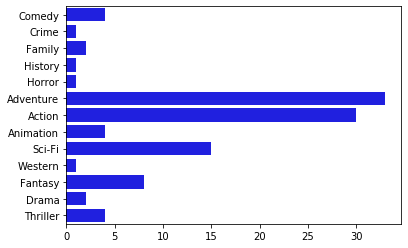

In [46]:
sns.barplot(y = keys, x = values, color = 'blue')